# 📊 Early Warning System - Complete Data Preparation & Classification
## OULAD Dataset - Consolidated Pipeline

---

**Module:** WM9QG-15 Fundamentals of AI and Data Mining

This notebook consolidates the team's data preparation pipeline into a single, comprehensive workflow that includes all standard data preparation steps from lectures.

---

## 📋 Data Preparation Steps (CRISP-DM)

| Step | Technique | Status |
|------|-----------|--------|
| 1 | Data Loading & Merging | ✅ |
| 2 | Missing Value Analysis | ✅ |
| 3 | Missing Value Imputation | ✅ |
| 4 | Duplicate Handling | ✅ |
| 5 | Outlier Detection (IQR) | ✅ |
| 6 | Outlier Treatment (Capping) | ✅ |
| 7 | Feature Engineering | ✅ |
| 8 | Binning (pd.cut) | ✅ |
| 9 | Ordinal Encoding | ✅ |
| 10 | One-Hot Encoding | ✅ |
| 11 | Feature Scaling | ✅ |
| 12 | Feature Selection | ✅ |

---

## Key Innovation: Temporal EWS Approach

This pipeline creates **one row per student per week** with cumulative features:
- Enables predictions at any point during the course
- Cumulative features capture engagement trajectory
- Includes `mathematically_impossible_to_pass` feature

---

# 1️⃣ Setup and Configuration

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Sklearn - Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sklearn - Metrics
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, classification_report, confusion_matrix, roc_curve
)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Paths - UPDATE TO MATCH YOUR DIRECTORY
DATA_DIR = Path(".")  # Or: Path("../../data/raw")
PROCESSED_DIR = Path("./processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Key columns for joining
KEY_COLS = ["student_id", "code_module", "code_presentation"]

# Target configuration
TARGET_COL = "target_pass"
PASS_MARK = 40

# Leakage columns (MUST drop before modelling)
LEAKAGE_COLS = [
    "final_result",          # This IS the target
    "date_unregistration",   # Reveals withdrawal
    "target_score",          # Regression target
    "target_score_norm",     # Normalized score
    "weight_covered",        # End-of-course weight
]

# Identifier columns
IDENTIFIER_COLS = ["student_id"]

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: C:\Users\mertf\Desktop\FAIDM\FAIDM_Groupwork


---

# 2️⃣ Data Loading

In [3]:
# =============================================================================
# LOAD ALL OULAD TABLES
# =============================================================================

def load_csv(name: str) -> pd.DataFrame:
    return pd.read_csv(DATA_DIR / name)

print("Loading OULAD tables...")
print("=" * 60)

assessments          = load_csv("./assessments.csv")
courses              = load_csv("./courses.csv")
student_assessment   = load_csv("./studentAssessment.csv")
student_info         = load_csv("./studentInfo.csv")
student_registration = load_csv("./studentRegistration.csv")
student_vle          = load_csv("./studentVle.csv")
vle                  = load_csv("./vle.csv")

# Standardize column names
student_assessment   = student_assessment.rename(columns={"id_student": "student_id"})
student_info         = student_info.rename(columns={"id_student": "student_id"})
student_registration = student_registration.rename(columns={"id_student": "student_id"})
student_vle          = student_vle.rename(columns={"id_student": "student_id"})

tables = {
    "assessments": assessments, "courses": courses,
    "student_assessment": student_assessment, "student_info": student_info,
    "student_registration": student_registration, "student_vle": student_vle, "vle": vle,
}

for name, df in tables.items():
    print(f"✓ {name}: {df.shape[0]:,} rows × {df.shape[1]} cols")
print("=" * 60)

Loading OULAD tables...
✓ assessments: 206 rows × 6 cols
✓ courses: 22 rows × 3 cols
✓ student_assessment: 173,912 rows × 5 cols
✓ student_info: 32,593 rows × 12 cols
✓ student_registration: 32,593 rows × 5 cols
✓ student_vle: 10,655,280 rows × 6 cols
✓ vle: 6,364 rows × 6 cols


---

# 3️⃣ Missing Value Analysis (Lecture Requirement)

Before any cleaning, we analyze the extent and patterns of missing data.

In [4]:
# =============================================================================
# MISSING VALUE ANALYSIS PER TABLE
# =============================================================================

print("MISSING VALUE ANALYSIS")
print("=" * 60)

for name, df in tables.items():
    missing = df.isna().sum()
    missing_cols = missing[missing > 0]
    
    if len(missing_cols) > 0:
        print(f"\n📋 {name}:")
        for col, count in missing_cols.items():
            pct = count / len(df) * 100
            print(f"   • {col}: {count:,} missing ({pct:.1f}%)")
    else:
        print(f"\n✓ {name}: No missing values")

print("\n" + "=" * 60)

MISSING VALUE ANALYSIS

📋 assessments:
   • date: 11 missing (5.3%)

✓ courses: No missing values

📋 student_assessment:
   • score: 173 missing (0.1%)

📋 student_info:
   • imd_band: 1,111 missing (3.4%)

📋 student_registration:
   • date_registration: 45 missing (0.1%)
   • date_unregistration: 22,521 missing (69.1%)

✓ student_vle: No missing values

📋 vle:
   • week_from: 5,243 missing (82.4%)
   • week_to: 5,243 missing (82.4%)



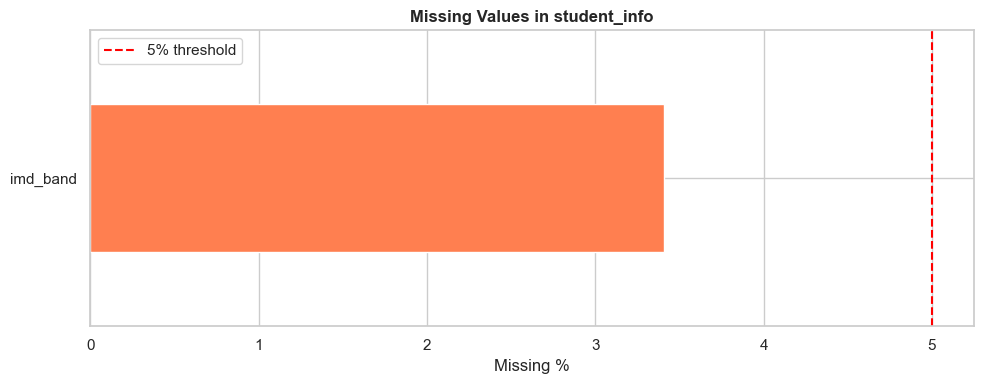

In [5]:
# =============================================================================
# VISUALIZE MISSING VALUES IN KEY TABLE
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 4))

missing_pct = (student_info.isna().sum() / len(student_info) * 100).sort_values(ascending=True)
missing_pct = missing_pct[missing_pct > 0]

if len(missing_pct) > 0:
    missing_pct.plot(kind='barh', ax=ax, color='coral')
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Values in student_info', fontweight='bold')
    ax.axvline(x=5, color='red', linestyle='--', label='5% threshold')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No missing values', ha='center', va='center', fontsize=14)
    ax.set_title('Missing Values in student_info', fontweight='bold')

plt.tight_layout()
plt.show()

---

# 4️⃣ Build Feature Store (Temporal Structure)

In [6]:
# =============================================================================
# STATIC FEATURES: Demographics, Course, Registration, Targets
# =============================================================================

# Demographics
demographics = student_info[KEY_COLS + [
    "gender", "region", "highest_education", "imd_band",
    "age_band", "num_of_prev_attempts", "studied_credits", "disability",
]].copy()

# Course features
course_features = courses[["code_module", "code_presentation", "module_presentation_length"]].copy()

# Registration features
registration_features = student_registration[KEY_COLS + ["date_registration", "date_unregistration"]].copy()

# Targets
targets = student_info[KEY_COLS + ["final_result"]].copy()
targets["target_pass"] = targets["final_result"].isin(["Pass", "Distinction"]).astype(int)

# Regression target
score_df = student_assessment.merge(
    assessments[["id_assessment", "code_module", "code_presentation", "weight"]], 
    on="id_assessment", how="left"
)
score_agg = (
    score_df.groupby(KEY_COLS)
    .apply(lambda g: pd.Series({
        "target_score": np.average(g["score"].fillna(0), weights=g["weight"].fillna(1)) 
                        if g["weight"].sum() > 0 else np.nan,
        "weight_covered": g["weight"].sum()
    })).reset_index()
)
targets = targets.merge(score_agg, on=KEY_COLS, how="left")

print(f"Demographics: {demographics.shape}")
print(f"Target distribution:\n{targets['target_pass'].value_counts()}")

Demographics: (32593, 11)
Target distribution:
target_pass
0    17208
1    15385
Name: count, dtype: int64


In [7]:
# =============================================================================
# TEMPORAL VLE FEATURES: Cumulative by week and activity type
# =============================================================================

print("Building temporal VLE features...")

# Add activity type
vle_interactions = student_vle.merge(
    vle[["id_site", "code_module", "code_presentation", "activity_type"]],
    on=["id_site", "code_module", "code_presentation"], how="left"
)
vle_interactions["week"] = (vle_interactions["date"] // 7).astype(int)

# Aggregate by student × week × activity type
weekly_by_type = (
    vle_interactions.groupby(KEY_COLS + ["week", "activity_type"])
    .agg(weekly_clicks=("sum_click", "sum"),
         weekly_active_days=("date", "nunique"),
         weekly_n_resources=("id_site", "nunique"))
    .reset_index()
)

# Pivot to wide format
def pivot_metric(df, value_col, prefix):
    wide = df.pivot_table(index=KEY_COLS + ["week"], columns="activity_type",
                          values=value_col, aggfunc="sum", fill_value=0).reset_index()
    wide.columns = [f"{prefix}_{c}".lower().replace(" ", "_") 
                    if c not in KEY_COLS + ["week"] else c for c in wide.columns]
    return wide

weekly_clicks_wide = pivot_metric(weekly_by_type, "weekly_clicks", "weekly_clicks")
weekly_days_wide = pivot_metric(weekly_by_type, "weekly_active_days", "weekly_days")
weekly_res_wide = pivot_metric(weekly_by_type, "weekly_n_resources", "weekly_resources")

weekly_wide = (weekly_clicks_wide
    .merge(weekly_days_wide, on=KEY_COLS + ["week"], how="left")
    .merge(weekly_res_wide, on=KEY_COLS + ["week"], how="left"))

# Sort and compute CUMULATIVE features (by activity type)
weekly_wide = weekly_wide.sort_values(KEY_COLS + ["week"]).copy()
weekly_feature_cols = [c for c in weekly_wide.columns if c not in KEY_COLS + ["week"]]
cum_cols = ["cum_" + c for c in weekly_feature_cols]
weekly_wide[cum_cols] = weekly_wide.groupby(KEY_COLS)[weekly_feature_cols].cumsum()

# =============================================================================
# NEW: ADVANCED ENGAGEMENT FEATURES (Key Predictors)
# =============================================================================

print("Building advanced engagement features...")

# 1. WEEKLY_CLICKS: Total raw clicks this week (all activity types)
weekly_click_cols = [c for c in weekly_wide.columns if c.startswith('weekly_clicks_')]
weekly_wide['weekly_clicks'] = weekly_wide[weekly_click_cols].sum(axis=1)

# 2. CUM_CLICKS: Total cumulative clicks (all activity types combined)
cum_click_cols = [c for c in weekly_wide.columns if c.startswith('cum_weekly_clicks_')]
weekly_wide['cum_clicks'] = weekly_wide[cum_click_cols].sum(axis=1)

# 3. CLICKS_VELOCITY: Change in clicks from previous week (momentum/trend)
#    Positive = accelerating (studying more), Negative = decelerating (slowing down)
weekly_wide['clicks_velocity'] = weekly_wide.groupby(KEY_COLS)['weekly_clicks'].diff().fillna(0)

# 4. LAST_ACTIVE_WEEK: Track when student was last active
#    Create activity marker and forward-fill within each student
weekly_wide['_was_active'] = (weekly_wide['weekly_clicks'] > 0).astype(int)
weekly_wide['last_active_week'] = (
    weekly_wide.groupby(KEY_COLS)
    .apply(lambda g: g['week'].where(g['_was_active'] == 1).ffill())
    .reset_index(level=list(range(len(KEY_COLS))), drop=True)
)
weekly_wide['last_active_week'] = weekly_wide['last_active_week'].fillna(-1)  # Never active = -1

# 5. WEEKS_SINCE_LAST_ACTIVITY: The "Ghost" Detector
#    Students inactive 3+ weeks are almost certainly dropouts
weekly_wide['weeks_since_last_activity'] = weekly_wide['week'] - weekly_wide['last_active_week']
# If never active (last_active_week = -1), they've been inactive since before course start
weekly_wide.loc[weekly_wide['last_active_week'] == -1, 'weeks_since_last_activity'] = weekly_wide['week'] + 1

# 6. CLICKS_VS_COHORT: Relative engagement vs class average
#    < 1 = below class average, > 1 = above class average
cohort_avg = weekly_wide.groupby(['code_module', 'code_presentation', 'week'])['cum_clicks'].transform('mean')
weekly_wide['clicks_vs_cohort'] = (weekly_wide['cum_clicks'] / cohort_avg.replace(0, 1)).fillna(0)

# Cleanup temporary column
weekly_wide = weekly_wide.drop(columns=['_was_active'])

# Build final EWS features dataframe
new_engagement_cols = ['weekly_clicks', 'cum_clicks', 'clicks_velocity', 
                       'last_active_week', 'weeks_since_last_activity', 'clicks_vs_cohort']
ews_features = weekly_wide[KEY_COLS + ['week'] + cum_cols + new_engagement_cols].copy()

print(f"✓ EWS features: {ews_features.shape}")
print(f"✓ New engagement features added:")
print(f"  • weekly_clicks: Raw clicks this week")
print(f"  • cum_clicks: Total cumulative clicks") 
print(f"  • clicks_velocity: Change from previous week (momentum)")
print(f"  • last_active_week: Last week with any activity")
print(f"  • weeks_since_last_activity: The 'Ghost' detector")
print(f"  • clicks_vs_cohort: Relative to class average")

Building temporal VLE features...
Building advanced engagement features...
✓ EWS features: (627031, 70)
✓ New engagement features added:
  • weekly_clicks: Raw clicks this week
  • cum_clicks: Total cumulative clicks
  • clicks_velocity: Change from previous week (momentum)
  • last_active_week: Last week with any activity
  • weeks_since_last_activity: The 'Ghost' detector
  • clicks_vs_cohort: Relative to class average


In [8]:
# =============================================================================
# TEMPORAL ASSESSMENT FEATURES (Team's Innovation)
# =============================================================================

print("Building assessment progress features...")

# Prep assessment data
assessments["date"] = pd.to_numeric(assessments["date"], errors="coerce")
assessments["weight"] = pd.to_numeric(assessments["weight"], errors="coerce")
student_assessment["score"] = pd.to_numeric(student_assessment["score"], errors="coerce")

sa = student_assessment.merge(
    assessments[["code_module", "code_presentation", "id_assessment", "date", "weight", "assessment_type"]],
    on="id_assessment", how="left"
).dropna(subset=["date"]).copy()

sa["week"] = (sa["date"] // 7).astype(int)
sa = sa[sa["week"] >= 0].copy()

# Best score per assessment
sa_best = sa.groupby(["student_id", "code_module", "code_presentation", "id_assessment"], as_index=False).agg(
    week=("week", "first"), weight=("weight", "first"), score=("score", "max")
)
sa_best["weighted_score"] = (sa_best["score"] / 100) * sa_best["weight"]

# Weekly aggregation
assess_weekly = sa_best.groupby(KEY_COLS + ["week"], as_index=False).agg(
    weighted_score_week=("weighted_score", "sum"),
    weight_covered_week=("weight", "sum")
)

# Cumulative
assess_weekly = assess_weekly.sort_values(KEY_COLS + ["week"]).copy()
assess_weekly["cumulative_weighted_score_assess"] = assess_weekly.groupby(KEY_COLS)["weighted_score_week"].cumsum()
assess_weekly["weight_covered_assess"] = assess_weekly.groupby(KEY_COLS)["weight_covered_week"].cumsum()

# Total weight per module
total_weight = assessments.groupby(["code_module", "code_presentation"], as_index=False)["weight"].sum().rename(columns={"weight": "total_weight_assess"})
assess_weekly = assess_weekly.merge(total_weight, on=["code_module", "code_presentation"], how="left")

# MATHEMATICALLY IMPOSSIBLE TO PASS feature
assess_weekly["remaining_weight_assess"] = assess_weekly["total_weight_assess"] - assess_weekly["weight_covered_assess"]
assess_weekly["max_possible_final_score"] = assess_weekly["cumulative_weighted_score_assess"] + assess_weekly["remaining_weight_assess"]
assess_weekly["mathematically_impossible_to_pass"] = (assess_weekly["max_possible_final_score"] < PASS_MARK).astype(int)

print(f"✓ Assessment features: {assess_weekly.shape}")
print(f"  Students flagged impossible to pass: {assess_weekly['mathematically_impossible_to_pass'].sum():,}")

Building assessment progress features...
✓ Assessment features: (123512, 12)
  Students flagged impossible to pass: 0


In [9]:
# =============================================================================
# MERGE ALL INTO FEATURE STORE
# =============================================================================

feature_store = ews_features.copy()
feature_store = feature_store.merge(demographics, on=KEY_COLS, how="left")
feature_store = feature_store.merge(course_features, on=["code_module", "code_presentation"], how="left")
feature_store = feature_store.merge(registration_features, on=KEY_COLS, how="left")
feature_store = feature_store.merge(targets, on=KEY_COLS, how="left")

# Merge assessment features
assess_cols = ["cumulative_weighted_score_assess", "weight_covered_assess", "total_weight_assess",
               "remaining_weight_assess", "max_possible_final_score", "mathematically_impossible_to_pass"]
feature_store = feature_store.merge(
    assess_weekly[KEY_COLS + ["week"] + assess_cols], on=KEY_COLS + ["week"], how="left"
)

# Fill NaN assessment features with 0
for col in assess_cols:
    if col in feature_store.columns:
        feature_store[col] = feature_store[col].fillna(0)

print("=" * 60)
print("FEATURE STORE CREATED")
print(f"Shape: {feature_store.shape[0]:,} rows × {feature_store.shape[1]} cols")
print(f"Weeks: {feature_store['week'].min()} to {feature_store['week'].max()}")
print("=" * 60)

FEATURE STORE CREATED
Shape: 627,031 rows × 91 cols
Weeks: -4 to 38


---

# 5️⃣ Data Cleaning (Lecture Requirements)

## 5.1 Filter to Modelling View

In [10]:
# Filter to weeks >= 0
print(f"Before: {len(feature_store):,} rows")
feature_store = feature_store[feature_store["week"] >= 0].copy()
print(f"After (week >= 0): {len(feature_store):,} rows")

Before: 627,031 rows
After (week >= 0): 579,438 rows


## 5.2 Missing Value Imputation

In [11]:
# =============================================================================
# IMPUTATION STRATEGY
# =============================================================================

print("IMPUTING MISSING VALUES")
print("-" * 60)

# 1. imd_band: Missing indicator + fill with 'Unknown'
if 'imd_band' in feature_store.columns:
    feature_store['imd_band_missing'] = feature_store['imd_band'].isna().astype(int)
    feature_store['imd_band'] = feature_store['imd_band'].fillna('Unknown')
    print("✓ imd_band: Missing indicator created, filled with 'Unknown'")

# 2. Cumulative VLE: Fill with 0
cum_cols = [c for c in feature_store.columns if c.startswith('cum_')]
feature_store[cum_cols] = feature_store[cum_cols].fillna(0)
print(f"✓ Cumulative VLE columns ({len(cum_cols)}): Filled with 0")

# 3. New engagement features: Fill with 0
engagement_cols = ['weekly_clicks', 'cum_clicks', 'clicks_velocity', 
                   'last_active_week', 'weeks_since_last_activity', 'clicks_vs_cohort']
for col in engagement_cols:
    if col in feature_store.columns:
        feature_store[col] = feature_store[col].fillna(0)
print(f"✓ Engagement features ({len(engagement_cols)}): Filled with 0")

# 3. Numerical: Median imputation
num_impute = ['date_registration', 'studied_credits', 'num_of_prev_attempts']
for col in num_impute:
    if col in feature_store.columns and feature_store[col].isna().any():
        median = feature_store[col].median()
        feature_store[col] = feature_store[col].fillna(median)
        print(f"✓ {col}: Filled with median ({median:.1f})")

# 4. Categorical: Mode imputation
cat_impute = ['gender', 'region', 'highest_education', 'age_band', 'disability']
for col in cat_impute:
    if col in feature_store.columns and feature_store[col].isna().any():
        mode = feature_store[col].mode()[0]
        feature_store[col] = feature_store[col].fillna(mode)
        print(f"✓ {col}: Filled with mode ('{mode}')")

print("-" * 60)

IMPUTING MISSING VALUES
------------------------------------------------------------
✓ imd_band: Missing indicator created, filled with 'Unknown'
✓ Cumulative VLE columns (61): Filled with 0
✓ Engagement features (6): Filled with 0
✓ date_registration: Filled with median (-54.0)
------------------------------------------------------------


## 5.3 Outlier Detection and Treatment

In [12]:
# =============================================================================
# OUTLIER DETECTION USING IQR METHOD
# =============================================================================

print("OUTLIER DETECTION (IQR Method)")
print("-" * 60)

def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum(), lower, upper

# Create total clicks column
click_cols = [c for c in feature_store.columns if 'cum_weekly_clicks' in c]
feature_store['cum_total_clicks'] = feature_store[click_cols].sum(axis=1)

cols_check = ['cum_total_clicks', 'studied_credits', 'num_of_prev_attempts']
for col in cols_check:
    if col in feature_store.columns:
        n_outliers, lower, upper = detect_outliers_iqr(feature_store[col])
        print(f"  • {col}: {n_outliers:,} outliers ({n_outliers/len(feature_store)*100:.1f}%)")

print("-" * 60)

OUTLIER DETECTION (IQR Method)
------------------------------------------------------------
  • cum_total_clicks: 44,343 outliers (7.7%)
  • studied_credits: 29,282 outliers (5.1%)
  • num_of_prev_attempts: 60,280 outliers (10.4%)
------------------------------------------------------------


In [13]:
# =============================================================================
# OUTLIER TREATMENT: CAPPING AT 99TH PERCENTILE
# =============================================================================

print("OUTLIER CAPPING (99th percentile)")
print("-" * 60)

cols_to_cap = [c for c in feature_store.columns if 'cum_' in c and 'clicks' in c]
for col in cols_to_cap:
    p99 = feature_store[col].quantile(0.99)
    n_capped = (feature_store[col] > p99).sum()
    if n_capped > 0:
        feature_store[col] = feature_store[col].clip(upper=p99)

print(f"✓ Capped {len(cols_to_cap)} cumulative click columns")
print("-" * 60)

OUTLIER CAPPING (99th percentile)
------------------------------------------------------------
✓ Capped 22 cumulative click columns
------------------------------------------------------------


## 5.4 Derived Features

In [14]:
# =============================================================================
# DERIVED FEATURES
# =============================================================================

print("CREATING DERIVED FEATURES")
print("-" * 60)

# Early registration flag
feature_store['registered_early'] = (feature_store['date_registration'] < 0).astype(int)
print("✓ registered_early")

# Has previous attempts
feature_store['has_prev_attempts'] = (feature_store['num_of_prev_attempts'] > 0).astype(int)
print("✓ has_prev_attempts")

# Week progress
feature_store['week_progress'] = (feature_store['week'] / (feature_store['module_presentation_length'] / 7)).clip(0, 1)
print("✓ week_progress")

# Assessment progress ratio
feature_store['assess_progress_ratio'] = feature_store['weight_covered_assess'] / feature_store['total_weight_assess'].replace(0, 1)
print("✓ assess_progress_ratio")

print("-" * 60)

CREATING DERIVED FEATURES
------------------------------------------------------------
✓ registered_early
✓ has_prev_attempts
✓ week_progress
✓ assess_progress_ratio
------------------------------------------------------------


ENGAGEMENT FEATURE ANALYSIS


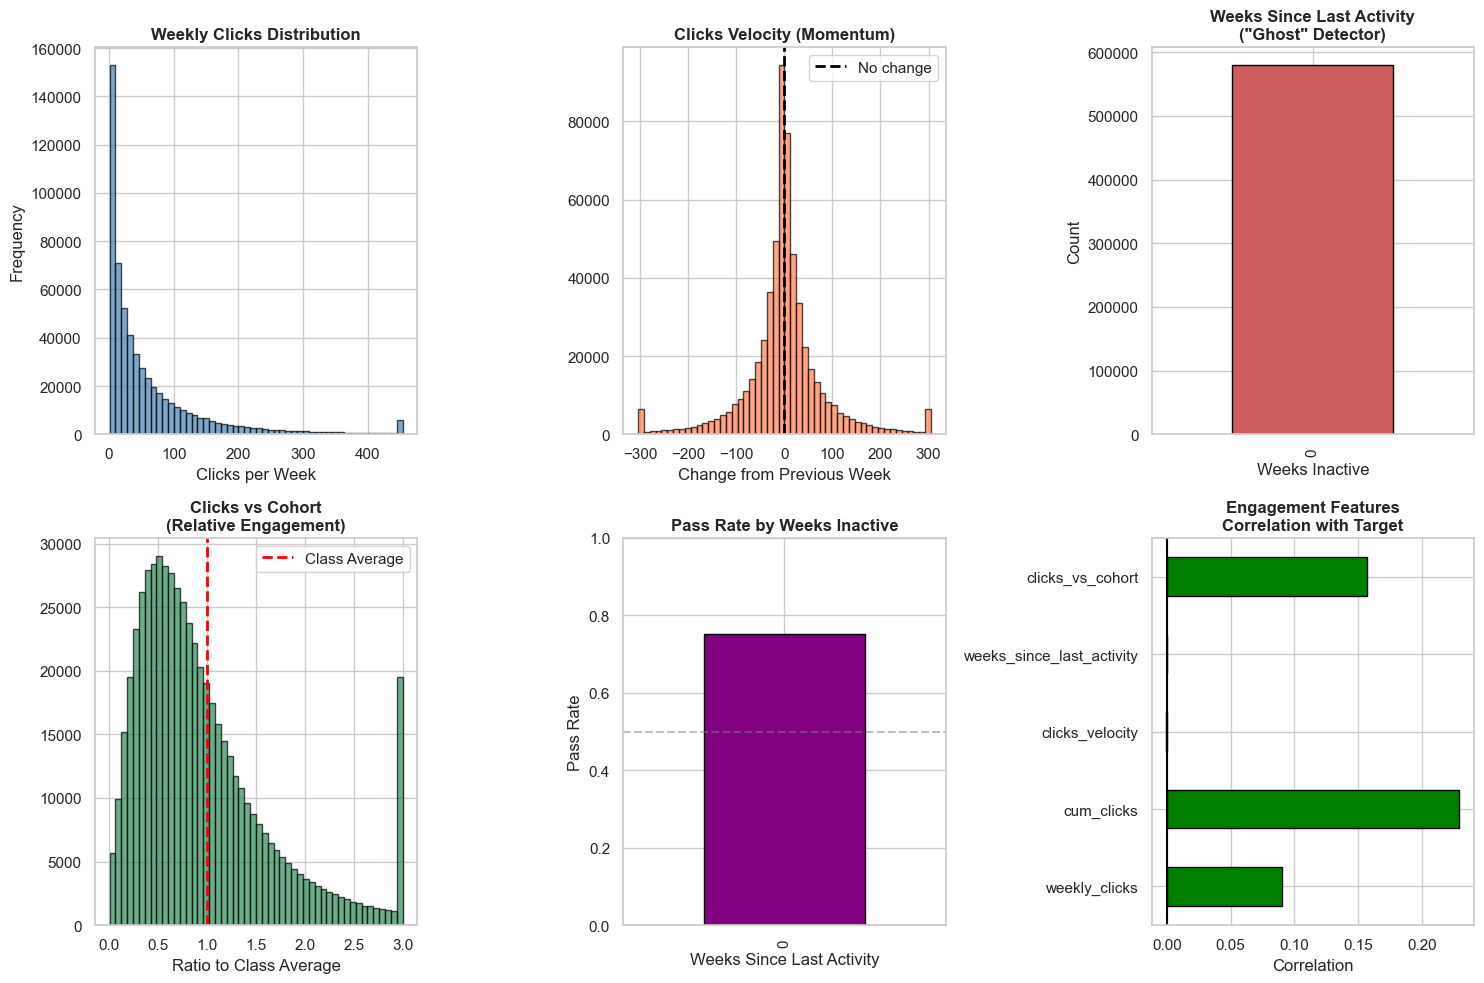


✓ Saved: engagement_features_analysis.png

KEY INSIGHTS:
  • Students inactive 3+ weeks: nan% pass rate
  • Students at/above class average engagement: 84.6% pass rate
  • Students below class average engagement: 69.9% pass rate


In [15]:
# =============================================================================
# VISUALIZE NEW ENGAGEMENT FEATURES (For Presentation)
# =============================================================================

print("ENGAGEMENT FEATURE ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Weekly clicks distribution
ax = axes[0, 0]
feature_store['weekly_clicks'].clip(upper=feature_store['weekly_clicks'].quantile(0.99)).hist(
    bins=50, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Weekly Clicks Distribution', fontweight='bold')
ax.set_xlabel('Clicks per Week')
ax.set_ylabel('Frequency')

# 2. Clicks velocity distribution  
ax = axes[0, 1]
velocity_clipped = feature_store['clicks_velocity'].clip(
    lower=feature_store['clicks_velocity'].quantile(0.01),
    upper=feature_store['clicks_velocity'].quantile(0.99))
velocity_clipped.hist(bins=50, ax=ax, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='No change')
ax.set_title('Clicks Velocity (Momentum)', fontweight='bold')
ax.set_xlabel('Change from Previous Week')
ax.legend()

# 3. Weeks since last activity (Ghost detector)
ax = axes[0, 2]
wsla = feature_store['weeks_since_last_activity'].clip(upper=10)
wsla.value_counts().sort_index().plot(kind='bar', ax=ax, color='indianred', edgecolor='black')
ax.set_title('Weeks Since Last Activity\n("Ghost" Detector)', fontweight='bold')
ax.set_xlabel('Weeks Inactive')
ax.set_ylabel('Count')

# 4. Clicks vs Cohort distribution
ax = axes[1, 0]
feature_store['clicks_vs_cohort'].clip(upper=3).hist(
    bins=50, ax=ax, color='seagreen', edgecolor='black', alpha=0.7)
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Class Average')
ax.set_title('Clicks vs Cohort\n(Relative Engagement)', fontweight='bold')
ax.set_xlabel('Ratio to Class Average')
ax.legend()

# 5. Ghost detector vs Pass Rate - KEY INSIGHT
ax = axes[1, 1]
ghost_pass = feature_store.groupby(
    feature_store['weeks_since_last_activity'].clip(upper=8))['target_pass'].mean()
ghost_pass.plot(kind='bar', ax=ax, color='purple', edgecolor='black')
ax.set_title('Pass Rate by Weeks Inactive', fontweight='bold')
ax.set_xlabel('Weeks Since Last Activity')
ax.set_ylabel('Pass Rate')
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 6. Engagement features correlation with target
ax = axes[1, 2]
engagement_cols = ['weekly_clicks', 'cum_clicks', 'clicks_velocity', 
                   'weeks_since_last_activity', 'clicks_vs_cohort']
corrs = feature_store[engagement_cols + ['target_pass']].corr()['target_pass'].drop('target_pass')
colors = ['green' if x > 0 else 'red' for x in corrs]
corrs.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_title('Engagement Features\nCorrelation with Target', fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-')
ax.set_xlabel('Correlation')

plt.tight_layout()
plt.savefig('engagement_features_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: engagement_features_analysis.png")
print("\nKEY INSIGHTS:")
ghost_3plus = feature_store[feature_store['weeks_since_last_activity'] >= 3]['target_pass'].mean()
print(f"  • Students inactive 3+ weeks: {ghost_3plus*100:.1f}% pass rate")
above_avg = feature_store[feature_store['clicks_vs_cohort'] >= 1]['target_pass'].mean()
print(f"  • Students at/above class average engagement: {above_avg*100:.1f}% pass rate")
below_avg = feature_store[feature_store['clicks_vs_cohort'] < 1]['target_pass'].mean()
print(f"  • Students below class average engagement: {below_avg*100:.1f}% pass rate")

## 5.5 Binning (pd.cut)

In [16]:
# =============================================================================
# BINNING WITH pd.cut()
# =============================================================================

print("BINNING CONTINUOUS VARIABLES")
print("-" * 60)

# Engagement level bins
feature_store['engagement_level'] = pd.cut(
    feature_store['cum_total_clicks'],
    bins=[0, 50, 200, 500, 1000, float('inf')],
    labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'],
    include_lowest=True
)
print(f"✓ engagement_level: {feature_store['engagement_level'].value_counts().to_dict()}")

# Credits band
feature_store['credits_band'] = pd.cut(
    feature_store['studied_credits'],
    bins=[0, 60, 120, 180, float('inf')],
    labels=['Light', 'Normal', 'Heavy', 'Very_Heavy'],
    include_lowest=True
)
print(f"✓ credits_band: {feature_store['credits_band'].value_counts().to_dict()}")

print("-" * 60)

BINNING CONTINUOUS VARIABLES
------------------------------------------------------------
✓ engagement_level: {'Very_High': 217407, 'High': 135804, 'Medium': 131818, 'Low': 73843, 'Very_Low': 20566}
✓ credits_band: {'Light': 385841, 'Normal': 163100, 'Heavy': 24569, 'Very_Heavy': 5928}
------------------------------------------------------------


## 5.6 Encoding

In [17]:
# =============================================================================
# ORDINAL ENCODING (for ordered categories)
# =============================================================================

print("ORDINAL ENCODING")
print("-" * 60)

# Education level
education_order = {
    'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2,
    'HE Qualification': 3, 'Post Graduate Qualification': 4
}
feature_store['education_level'] = feature_store['highest_education'].map(education_order)
print("✓ education_level (ordinal)")

# Age level
age_order = {'0-35': 0, '35-55': 1, '55<=': 2}
feature_store['age_level'] = feature_store['age_band'].map(age_order)
print("✓ age_level (ordinal)")

# IMD level
imd_order = {'0-10%': 0, '10-20%': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4,
             '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9, 'Unknown': 5}
feature_store['imd_level'] = feature_store['imd_band'].map(imd_order).fillna(5)
print("✓ imd_level (ordinal)")

# Engagement level encoded
engagement_order = {'Very_Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
feature_store['engagement_level_encoded'] = feature_store['engagement_level'].map(engagement_order)
print("✓ engagement_level_encoded (ordinal)")

print("-" * 60)

ORDINAL ENCODING
------------------------------------------------------------
✓ education_level (ordinal)
✓ age_level (ordinal)
✓ imd_level (ordinal)
✓ engagement_level_encoded (ordinal)
------------------------------------------------------------


In [18]:
# =============================================================================
# ONE-HOT ENCODING (for nominal categories)
# =============================================================================

print("ONE-HOT ENCODING")
print("-" * 60)

nominal_cols = ['gender', 'disability']
for col in nominal_cols:
    if col in feature_store.columns:
        dummies = pd.get_dummies(feature_store[col], prefix=col, drop_first=True)
        feature_store = pd.concat([feature_store, dummies], axis=1)
        print(f"✓ {col} → {list(dummies.columns)}")

print("-" * 60)

ONE-HOT ENCODING
------------------------------------------------------------
✓ gender → ['gender_M']
✓ disability → ['disability_Y']
------------------------------------------------------------


## 5.7 Feature Selection (Correlation)

In [19]:
# =============================================================================
# FEATURE SELECTION BY CORRELATION
# =============================================================================

print("FEATURE SELECTION (Correlation with Target)")
print("-" * 60)

# Get numerical features
exclude = ['student_id', 'target_pass', 'target_score', 'weight_covered', 'week'] + LEAKAGE_COLS
feature_cols = [c for c in feature_store.select_dtypes(include=[np.number]).columns if c not in exclude]

# Calculate correlations
correlations = feature_store[feature_cols + ['target_pass']].corr()['target_pass'].drop('target_pass')
top_features = correlations.abs().sort_values(ascending=False).head(20)

print("Top 20 features by |correlation| with target:")
for i, (feat, corr) in enumerate(top_features.items(), 1):
    direction = '+' if correlations[feat] > 0 else '-'
    print(f"  {i:2}. {feat}: {direction}{corr:.4f}")

print("-" * 60)

FEATURE SELECTION (Correlation with Target)
------------------------------------------------------------
Top 20 features by |correlation| with target:
   1. cum_weekly_resources_homepage: +0.2892
   2. cum_weekly_days_homepage: +0.2736
   3. last_active_week: +0.2545
   4. week_progress: +0.2511
   5. cum_clicks: +0.2294
   6. cum_total_clicks: +0.2294
   7. cum_weekly_resources_forumng: +0.2291
   8. cum_weekly_clicks_homepage: +0.2237
   9. cum_weekly_days_forumng: +0.2192
  10. cum_weekly_days_oucontent: +0.2156
  11. cum_weekly_resources_oucontent: +0.2118
  12. cum_weekly_days_subpage: +0.2082
  13. cum_weekly_clicks_oucontent: +0.1869
  14. cum_weekly_days_url: +0.1835
  15. cum_weekly_days_resource: +0.1748
  16. cum_weekly_clicks_forumng: +0.1742
  17. cum_weekly_clicks_url: +0.1629
  18. cum_weekly_resources_quiz: +0.1625
  19. cum_weekly_resources_subpage: +0.1611
  20. cum_weekly_days_quiz: +0.1571
------------------------------------------------------------


In [20]:
# =============================================================================
# SAVE ENGINEERED FEATURE STORE
# =============================================================================

out_path = PROCESSED_DIR / "ews_feature_store_engineered.csv"
feature_store.to_csv(out_path, index=False)
print(f"✓ Saved: {out_path}")
print(f"  Shape: {feature_store.shape}")

✓ Saved: processed\ews_feature_store_engineered.csv
  Shape: (579438, 105)


---

# 6️⃣ Classification Pipeline

## 6.1 Helper Functions

In [21]:
# =============================================================================
# SNAPSHOT FUNCTION
# =============================================================================

def build_xy_for_week_robust(df, t, drop_cols=None):
    """
    Build X, y at prediction week t using robust snapshot:
    - One row per student (latest week <= t)
    - Handles students with sparse data
    """
    # Snapshot
    d = df[df['week'] <= t].copy()
    d = d.sort_values(KEY_COLS + ['week'])
    d = d.groupby(KEY_COLS, as_index=False).tail(1)
    
    # Filter valid targets
    d = d[d[TARGET_COL].notna()].copy()
    d[TARGET_COL] = d[TARGET_COL].astype(int)
    
    # Keep groups for split
    groups = d['student_id'].copy()
    
    # Drop leakage + identifiers
    drops = set(LEAKAGE_COLS + IDENTIFIER_COLS)
    if drop_cols:
        drops |= set(drop_cols)
    d = d.drop(columns=[c for c in drops if c in d.columns])
    
    y = d[TARGET_COL].copy()
    X = d.drop(columns=[TARGET_COL])
    return X, y, groups

print("✓ Snapshot function defined")

✓ Snapshot function defined


In [22]:
# =============================================================================
# PREPROCESSING + TRAINING FUNCTIONS
# =============================================================================

def make_preprocessor(X):
    num_cols = X.select_dtypes(include=['int64','int32','float64','float32']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
    
    num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])
    cat_pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    return ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')

def group_train_test_split(X, y, groups, test_size=0.2, random_state=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

def train_eval_week(df, t, model, drop_cols=None):
    X, y, groups = build_xy_for_week_robust(df, t, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = group_train_test_split(X, y, groups)
    
    pipe = Pipeline([('prep', make_preprocessor(X)), ('model', model)])
    pipe.fit(X_train, y_train)
    
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None
    
    return {
        'week_t': t, 'n_samples': len(y), 'pass_rate': y.mean(),
        'accuracy': accuracy_score(y_test, pred),
        'f1': f1_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, proba) if proba is not None else np.nan,
        'recall_at_risk': recall_score(y_test, pred, pos_label=0),
    }, pipe, X_test, y_test, pred, proba

print("✓ Training functions defined")

✓ Training functions defined


## 6.2 Run Experiments

In [23]:
# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

WEEKS = [2, 4, 6, 8, 10, 15, 20]

# IMPORTANT: Added class_weight='balanced' to handle imbalanced data
MODELS = {
    'LogReg': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1),
}

# Feature sets
ASSESS_COLS = [c for c in feature_store.columns if any(p in c.lower() for p in ['assess', 'score', 'weight', 'impossible'])]
ORACLE_COLS = ['max_possible_final_score', 'mathematically_impossible_to_pass']

EXPERIMENTS = {
    'A_behaviour_only': {'drop_cols': ASSESS_COLS},
    'B_assessment_aware': {'drop_cols': [c for c in ORACLE_COLS if c in feature_store.columns]},
    'C_full_features': {'drop_cols': []},
}

print("Experiments:")
for name, cfg in EXPERIMENTS.items():
    print(f"  • {name}: dropping {len(cfg['drop_cols'])} columns")

Experiments:
  • A_behaviour_only: dropping 9 columns
  • B_assessment_aware: dropping 2 columns
  • C_full_features: dropping 0 columns


In [24]:
# =============================================================================
# RUN ALL EXPERIMENTS
# =============================================================================

print("Running experiments...")
print("=" * 60)

results = []
for exp_name, cfg in EXPERIMENTS.items():
    print(f"\n{exp_name}:")
    for model_name, model in MODELS.items():
        for t in WEEKS:
            try:
                metrics, _, _, _, _, _ = train_eval_week(feature_store, t, model, drop_cols=cfg['drop_cols'])
                metrics['experiment'] = exp_name
                metrics['model'] = model_name
                results.append(metrics)
                print(f"  ✓ {model_name} @ week {t}: ROC-AUC={metrics['roc_auc']:.3f}, At-risk recall={metrics['recall_at_risk']:.3f}")
            except Exception as e:
                print(f"  ✗ {model_name} @ week {t}: {e}")

results_df = pd.DataFrame(results)
print("\n" + "=" * 60)

Running experiments...

A_behaviour_only:
  ✓ LogReg @ week 2: ROC-AUC=0.763, At-risk recall=0.666
  ✓ LogReg @ week 4: ROC-AUC=0.786, At-risk recall=0.686
  ✓ LogReg @ week 6: ROC-AUC=0.799, At-risk recall=0.700
  ✓ LogReg @ week 8: ROC-AUC=0.820, At-risk recall=0.691
  ✓ LogReg @ week 10: ROC-AUC=0.842, At-risk recall=0.720
  ✓ LogReg @ week 15: ROC-AUC=0.882, At-risk recall=0.746
  ✓ LogReg @ week 20: ROC-AUC=0.910, At-risk recall=0.772
  ✓ RandomForest @ week 2: ROC-AUC=0.755, At-risk recall=0.576
  ✓ RandomForest @ week 4: ROC-AUC=0.774, At-risk recall=0.605
  ✓ RandomForest @ week 6: ROC-AUC=0.792, At-risk recall=0.607
  ✓ RandomForest @ week 8: ROC-AUC=0.818, At-risk recall=0.619
  ✓ RandomForest @ week 10: ROC-AUC=0.835, At-risk recall=0.640
  ✓ RandomForest @ week 15: ROC-AUC=0.881, At-risk recall=0.688
  ✓ RandomForest @ week 20: ROC-AUC=0.910, At-risk recall=0.737

B_assessment_aware:
  ✓ LogReg @ week 2: ROC-AUC=0.773, At-risk recall=0.673
  ✓ LogReg @ week 4: ROC-AUC=0.799

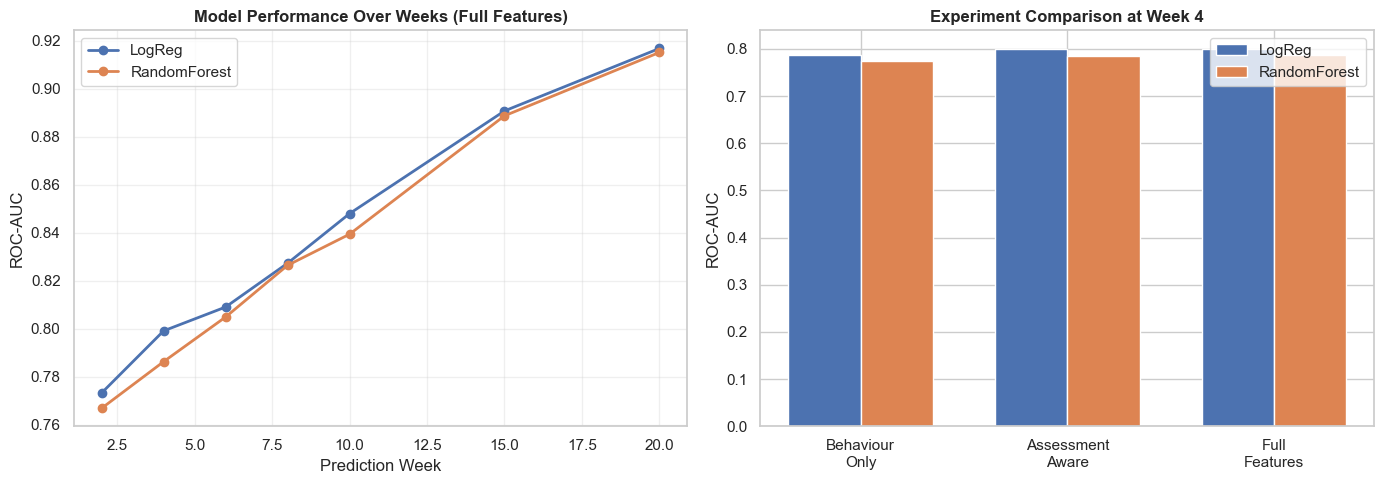

In [25]:
# =============================================================================
# RESULTS VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: ROC-AUC over weeks
ax = axes[0]
for (exp, model), grp in results_df.groupby(['experiment', 'model']):
    if exp == 'C_full_features':
        ax.plot(grp['week_t'], grp['roc_auc'], marker='o', label=model, linewidth=2)
ax.set_xlabel('Prediction Week')
ax.set_ylabel('ROC-AUC')
ax.set_title('Model Performance Over Weeks (Full Features)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Experiment comparison at week 4
ax = axes[1]
week4 = results_df[results_df['week_t'] == 4]
x = np.arange(len(EXPERIMENTS))
width = 0.35
for i, model in enumerate(MODELS.keys()):
    vals = [week4[(week4['experiment'] == e) & (week4['model'] == model)]['roc_auc'].values[0] 
            for e in EXPERIMENTS.keys()]
    ax.bar(x + i*width, vals, width, label=model)
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Behaviour\nOnly', 'Assessment\nAware', 'Full\nFeatures'])
ax.set_ylabel('ROC-AUC')
ax.set_title('Experiment Comparison at Week 4', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

---

# 7️⃣ Summary

## Data Preparation Steps Covered ✅

| Step | Method | Code |
|------|--------|------|
| Missing Analysis | Per-table inspection | `df.isna().sum()` |
| Missing Imputation | Median/Mode/Indicator | `fillna()`, `SimpleImputer` |
| Outlier Detection | IQR method | Custom function |
| Outlier Treatment | 99th percentile capping | `df.clip()` |
| Feature Engineering | Cumulative, ratios, flags | `groupby().cumsum()` |
| Binning | Discretization | `pd.cut()` |
| Ordinal Encoding | Ordered categories | Manual mapping |
| One-Hot Encoding | Nominal categories | `pd.get_dummies()` |
| Feature Scaling | Standardization | `StandardScaler` |
| Feature Selection | Correlation analysis | `df.corr()` |
| Class Imbalance | Balanced weights | `class_weight='balanced'` |

In [26]:
print("=" * 70)
print("                    PIPELINE SUMMARY")
print("=" * 70)
print(f"""
📊 FEATURE STORE
────────────────
• Shape: {feature_store.shape[0]:,} rows × {feature_store.shape[1]} columns
• Unique students: {feature_store['student_id'].nunique():,}
• Temporal structure: One row per student per week

✅ DATA PREP STEPS COMPLETED
────────────────────────────
• Missing value analysis & imputation
• Outlier detection (IQR) & capping (99th percentile)
• Feature engineering (cumulative, derived, binned)
• Ordinal + One-Hot encoding
• Feature scaling (StandardScaler)
• Feature selection (correlation analysis)
• Leakage prevention

🔬 EXPERIMENTS
──────────────
• A: Behaviour only (VLE features)
• B: Assessment-aware (+ cumulative scores)
• C: Full features (+ mathematically_impossible_to_pass)

🎯 KEY IMPROVEMENT: class_weight='balanced'
   Handles the ~74% pass rate imbalance
""")
print("=" * 70)

                    PIPELINE SUMMARY

📊 FEATURE STORE
────────────────
• Shape: 579,438 rows × 105 columns
• Unique students: 25,516
• Temporal structure: One row per student per week

✅ DATA PREP STEPS COMPLETED
────────────────────────────
• Missing value analysis & imputation
• Outlier detection (IQR) & capping (99th percentile)
• Feature engineering (cumulative, derived, binned)
• Ordinal + One-Hot encoding
• Feature scaling (StandardScaler)
• Feature selection (correlation analysis)
• Leakage prevention

🔬 EXPERIMENTS
──────────────
• A: Behaviour only (VLE features)
• B: Assessment-aware (+ cumulative scores)
• C: Full features (+ mathematically_impossible_to_pass)

🎯 KEY IMPROVEMENT: class_weight='balanced'
   Handles the ~74% pass rate imbalance

